In [2]:
import os
from pprint import pprint
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

sys.path.append("../")

from monkey.config import TrainingIOConfig
from monkey.data.dataset import get_detection_dataloaders
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from monkey.model.hovernext.model import (
    get_custom_hovernext,
    get_convnext_unet,
)
from monkey.model.loss_functions import get_loss_function
from monkey.model.utils import get_activation_function
from tqdm.autonotebook import tqdm
from monkey.model.utils import (
    get_multiclass_patch_F1_score_batch,
    get_patch_F1_score_batch,
)
from monkey.model.loss_functions import dice_coeff
from monkey.data.data_utils import imagenet_denormalise, dilate_mask

run_config = {
    "project_name": "Monkey_Multiclass_Detection",
    "model_name": "hovernext_det_large",
    "val_fold": 2,  # [1-5]
    "batch_size": 16,
    "optimizer": "AdamW",
    "learning_rate": 0.0004,
    "weight_decay": 0.01,
    "epochs": 50,
    "loss_function": {
        "head_1": "BCE_Dice",
        "head_2": "BCE_Dice",
    },
    "loss_pos_weight": 1.0,
    "do_augmentation": True,
    "activation_function": {
        "head_1": "sigmoid",
        "head_2": "sigmoid",
    },
    "use_nuclick_masks": False,  # Whether to use NuClick segmentation masks,
    "include_background_channel": False,
}

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
)
if run_config["use_nuclick_masks"]:
    # Use NuClick masks
    IOconfig.set_mask_dir(
        "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed"
    )

fold = run_config["val_fold"]
# Create model
# model = get_multihead_efficientunet(
#     out_channels=run_config["out_channels"], pretrained=False
# )
model = get_convnext_unet(
    enc="convnextv2_large.fcmae_ft_in22k_in1k",
    out_classes=2,
    pretrained=False,
    use_batchnorm=True,
    attention_type="scse",
)
checkpoint_path = f"/home/u1910100/Documents/Monkey/runs/Monkey_Detection_2_channel/hovernext_large_lizzard_pretrained_v2/fold_{fold}/best.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model"])
model.eval()
model.to("cuda")


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=run_config["batch_size"],
    do_augmentation=run_config["do_augmentation"],
    use_nuclick_masks=run_config["use_nuclick_masks"],
)


activation_dict = {
    "head_1": get_activation_function(
        run_config["activation_function"]["head_1"]
    ),
    "head_2": get_activation_function(
        run_config["activation_function"]["head_2"]
    ),
}

negative pixels: 730449808
lymph pixels: 6393156
mono pixels: 3517228
train patches: 11297
test patches: 3018


In [3]:
def hovernext_det_post_process(
    inflamm_prob: torch.Tensor,
    lymph_prob: torch.Tensor,
    mono_prob: torch.Tensor,
    thresholds: list = [0.5, 0.5, 0.5],
    min_distances: list = [11, 9, 13],
):

    inflamm_prob = inflamm_prob.numpy(force=True)
    lymph_prob = lymph_prob.numpy(force=True)
    mono_prob = mono_prob.numpy(force=True)

    inflamm_prob = np.squeeze(inflamm_prob, axis=1)
    lymph_prob = np.squeeze(lymph_prob, axis=1)
    mono_prob = np.squeeze(mono_prob, axis=1)

    batches = inflamm_prob.shape[0]
    inflamm_output_mask = np.zeros(shape=(batches, 256, 256))
    lymph_output_mask = np.zeros(shape=(batches, 256, 256))
    mono_output_mask = np.zeros(shape=(batches, 256, 256))

    for i in range(0, batches):
        inflamm_coordinates = peak_local_max(
            inflamm_prob[i],
            min_distance=min_distances[0],
            threshold_abs=thresholds[0],
            exclude_border=False,
        )
        inflamm_output_mask[i][
            inflamm_coordinates[:, 0], inflamm_coordinates[:, 1]
        ] = 1

        lymph_coordinates = peak_local_max(
            lymph_prob[i],
            min_distance=min_distances[1],
            threshold_abs=thresholds[1],
            exclude_border=False,
        )
        lymph_output_mask[i][
            lymph_coordinates[:, 0], lymph_coordinates[:, 1]
        ] = 1

        mono_coordinates = peak_local_max(
            mono_prob[i],
            min_distance=min_distances[2],
            threshold_abs=thresholds[2],
            exclude_border=False,
        )
        mono_output_mask[i][
            mono_coordinates[:, 0], mono_coordinates[:, 1]
        ] = 1

    return {
        "inflamm_mask": inflamm_output_mask,
        "lymph_mask": lymph_output_mask,
        "mono_mask": mono_output_mask,
    }

In [ ]:
running_overall_score = 0.0
running_lymph_score = 0.0
running_mono_score = 0.0
running_contour_score = 0.0

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):
    images = data["image"].cuda().float()
    inflamm_true_masks = data["binary_mask"][:, 0, :, :].numpy(
        force=True
    )
    lymph_true_masks = data["class_mask"][:, 0, :, :].numpy(
        force=True
    )
    mono_true_masks = data["class_mask"][:, 1, :, :].numpy(force=True)

    with torch.no_grad():
        logits_pred = model(images)
        lymph_logits = logits_pred[:, 0:1, :, :]
        mono_logits = logits_pred[:, 1:2, :, :]

        lymph_prob = activation_dict["head_1"](lymph_logits)
        mono_prob = activation_dict["head_2"](mono_logits)
        inflamm_prob = lymph_prob + mono_prob

        processed_output = hovernext_det_post_process(
            inflamm_prob,
            lymph_prob,
            mono_prob,
            thresholds=[0.5, 0.5, 0.5],
            min_distances=[7, 7, 7],
        )

    # Compute detection F1 score
    overall_metrics = get_patch_F1_score_batch(
        processed_output["inflamm_mask"],
        inflamm_true_masks,
        7.5,
        inflamm_prob[:, 0, :, :],
    )
    lymph_metrics = get_patch_F1_score_batch(
        processed_output["lymph_mask"],
        lymph_true_masks,
        4,
        lymph_prob[:, 0, :, :],
    )
    mono_metrics = get_patch_F1_score_batch(
        processed_output["mono_mask"],
        mono_true_masks,
        10,
        mono_prob[:, 0, :, :],
    )

    running_overall_score += (overall_metrics["F1"]) * images.size(0)
    running_lymph_score += (lymph_metrics["F1"]) * images.size(0)
    running_mono_score += (mono_metrics["F1"]) * images.size(0)

results = {
    "overall_F1": running_overall_score / len(val_loader.sampler),
    "lymph_F1": running_lymph_score / len(val_loader.sampler),
    "mono_F1": running_mono_score / len(val_loader.sampler),
}

pprint(results)

negative pixels: 730449808
lymph pixels: 6393156
mono pixels: 3517228
train patches: 11297
test patches: 3018


validation:   0%|          | 0/3018 [00:00<?, ?it/s]|2024-12-05|13:12:44.551| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


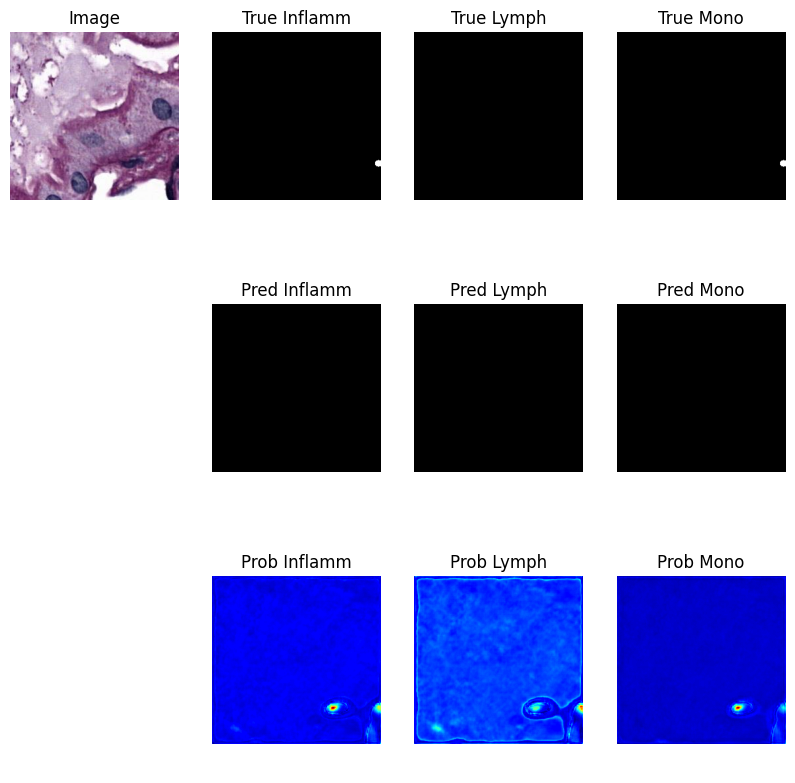

validation:   0%|          | 1/3018 [00:00<21:20,  2.36it/s]|2024-12-05|13:12:44.866| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


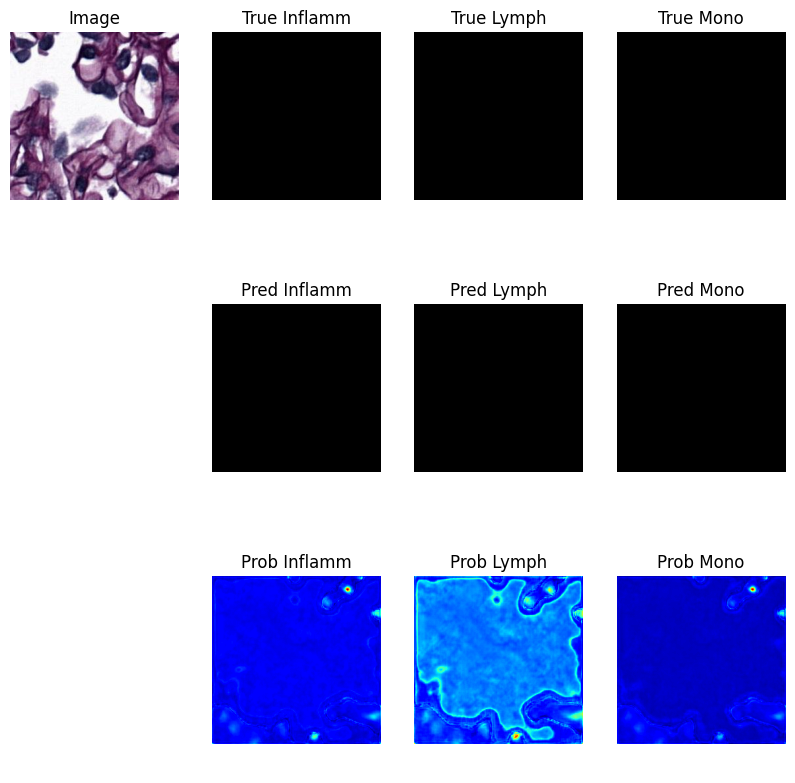

validation:   0%|          | 2/3018 [00:00<16:31,  3.04it/s]|2024-12-05|13:12:45.128| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


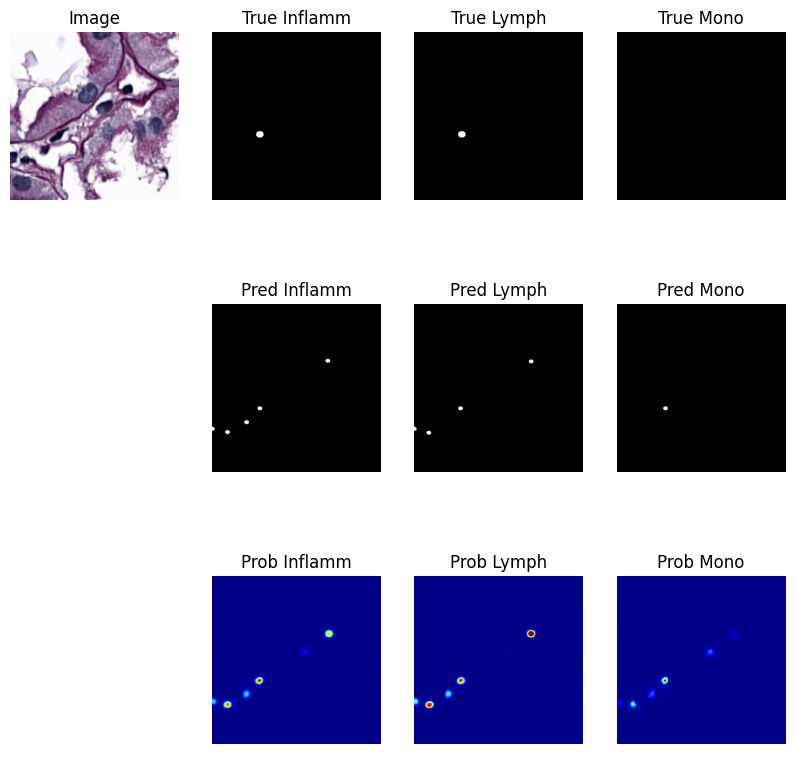

validation:   0%|          | 3/3018 [00:00<15:00,  3.35it/s]|2024-12-05|13:12:45.390| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


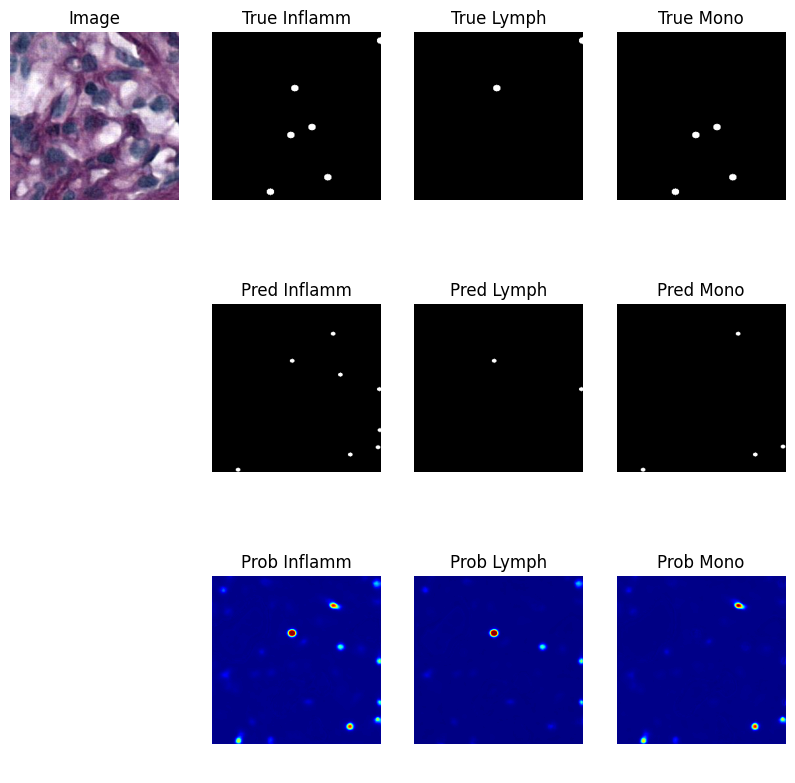

validation:   0%|          | 4/3018 [00:01<18:48,  2.67it/s]|2024-12-05|13:12:45.880| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


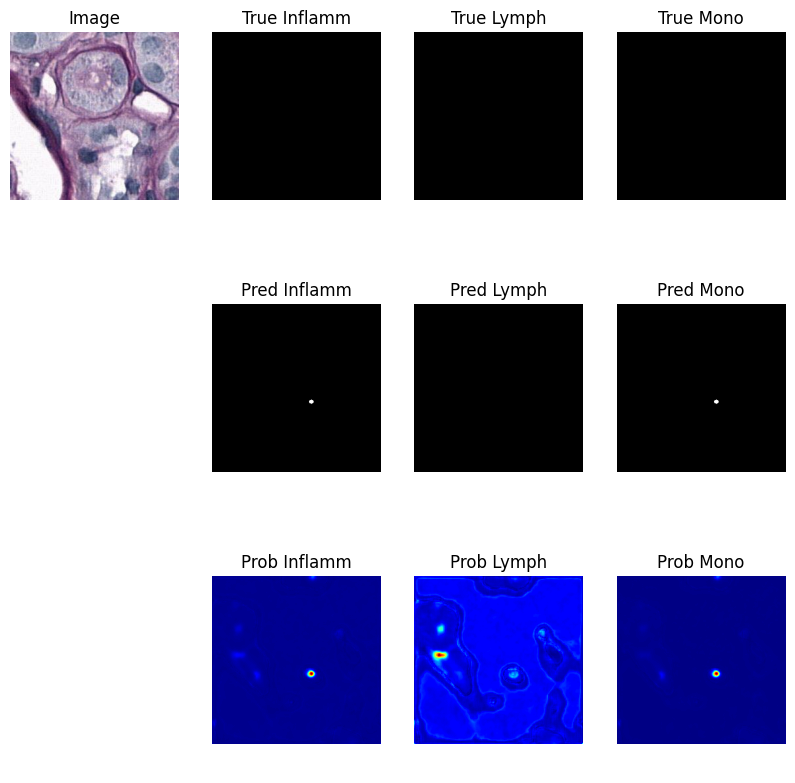

validation:   0%|          | 5/3018 [00:01<16:41,  3.01it/s]|2024-12-05|13:12:46.138| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


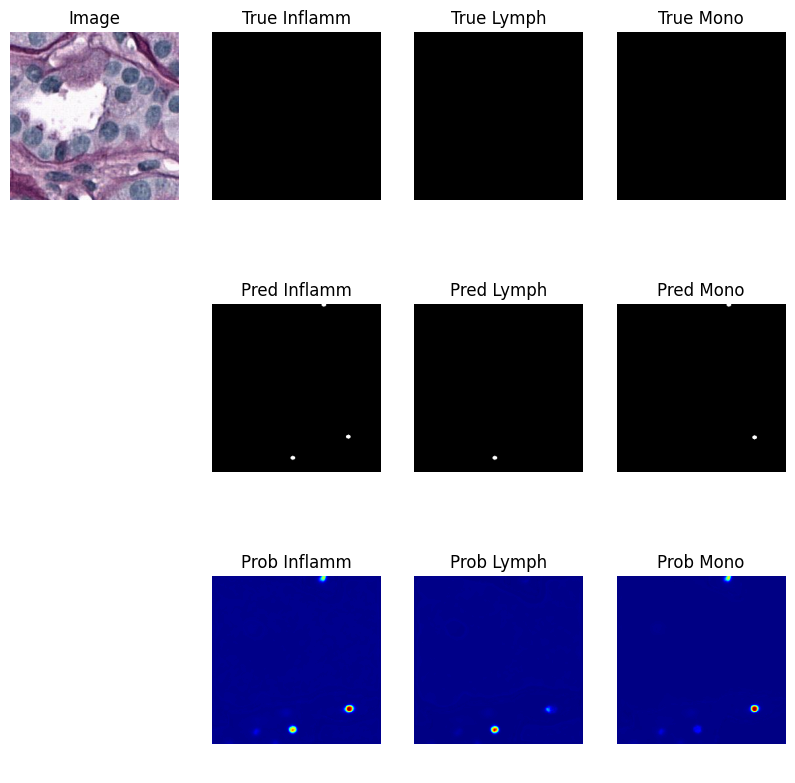

validation:   0%|          | 6/3018 [00:01<15:16,  3.29it/s]|2024-12-05|13:12:46.385| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


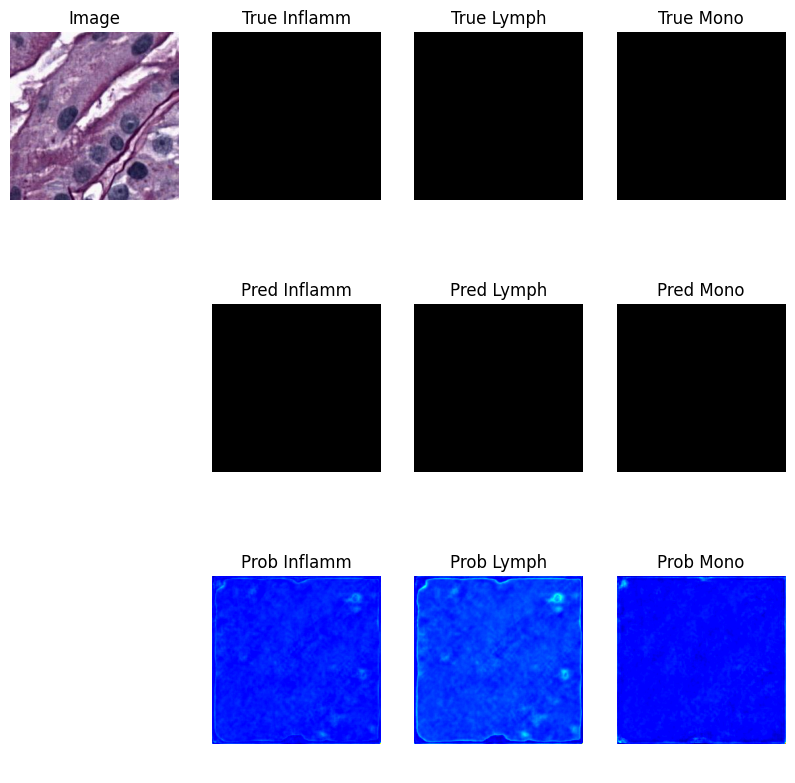

In [6]:
train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=1,
    do_augmentation=run_config["do_augmentation"],
    use_nuclick_masks=run_config["use_nuclick_masks"],
)

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):

    fig, axes = plt.subplots(3, 4, figsize=(10, 10))

    images = data["image"].cuda().float()
    inflamm_true_masks = data["binary_mask"][:, 0, :, :].numpy(
        force=True
    )
    lymph_true_masks = data["class_mask"][:, 0, :, :].numpy(
        force=True
    )
    mono_true_masks = data["class_mask"][:, 1, :, :].numpy(force=True)

    with torch.no_grad():
        logits_pred = model(images)
        lymph_logits = logits_pred[:, 0:1, :, :]
        mono_logits = logits_pred[:, 1:2, :, :]

        lymph_prob = activation_dict["head_1"](lymph_logits).cpu()
        mono_prob = activation_dict["head_2"](mono_logits).cpu()
        inflamm_prob = lymph_prob + mono_prob

        processed_output = hovernext_det_post_process(
            inflamm_prob,
            lymph_prob,
            mono_prob,
            thresholds=[0.5, 0.5, 0.5],
            min_distances=[7, 7, 7],
        )

    images = images.numpy(force=True)[0]
    images = np.moveaxis(images, 0, 2)
    images = imagenet_denormalise(images)

    axes[0][0].imshow(images)
    axes[0][0].set_title("Image")

    axes[0][1].imshow(inflamm_true_masks[0], cmap="gray")
    axes[0][1].set_title("True Inflamm")

    axes[2][1].imshow(inflamm_prob[0][0], cmap="jet")
    axes[2][1].set_title(f"Prob Inflamm")

    axes[0][2].imshow(lymph_true_masks[0], cmap="gray")
    axes[0][2].set_title("True Lymph")

    axes[0][3].imshow(mono_true_masks[0], cmap="gray")
    axes[0][3].set_title("True Mono")

    axes[2][3].imshow(mono_prob[0][0], cmap="jet")
    axes[2][3].set_title(f"Prob Mono")

    axes[1][2].imshow(
        dilate_mask(processed_output["lymph_mask"][0], 7), cmap="gray"
    )
    axes[1][2].set_title("Pred Lymph")

    axes[1][3].imshow(
        dilate_mask(processed_output["mono_mask"][0], 7), cmap="gray"
    )
    axes[1][3].set_title("Pred Mono")

    axes[1][1].imshow(
        dilate_mask(processed_output["inflamm_mask"][0], 7),
        cmap="gray",
    )
    axes[1][1].set_title("Pred Inflamm")

    axes[2][2].imshow(
        lymph_prob[0][0],
        cmap="jet",
    )
    axes[2][2].set_title(f"Prob Lymph")

    for ax in axes.ravel():
        ax.axis("off")
    plt.show()

    if i > 5:
        break